In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np
from collections import defaultdict

### Load the data and define some helpers

In [99]:
vfields = []
for f in glob('../data/vfields/seed-*.pkl'):
    with open(f, 'rb') as fp:
        vfields.append(pickle.load(fp))

len(vfields)

1000

In [100]:
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)

In [101]:
def get_vfields(seed: int, coef: float):
    for vf in vfields_by_level[seed]:
        if vf['coeff'] == coef:
            return vf

### Interactive vfield plot explorer

In [128]:
from ipywidgets import interact, IntSlider, FloatSlider

seed_max = max(vf['seed'] for vf in vfields)
min_coeff, max_coeff = min(vf['coeff'] for vf in vfields), max(vf['coeff'] for vf in vfields)

def _coeffs_for(seed: int):
    return sorted(set(vf['coeff'] for vf in vfields_by_level[seed]))

def plot_vfs(vfs):
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    for i, vf in enumerate((vfs['original_vfield'], vfs['patched_vfield'])):
        legal_mouse_positions, arrows, grid = vf['legal_mouse_positions'], vf['arrows'], vf['grid']

        ax[i].set_xlabel("Original vfield" if i == 0 else "Patched vfield")
        ax[i].quiver(
            [x[1] for x in legal_mouse_positions], [x[0] for x in legal_mouse_positions],
            [x[1] for x in arrows], [x[0] for x in arrows], color='red',
        )
        ax[i].imshow(grid, origin='lower')

    plt.title(f"Seed {vfs['seed']}, coeff {vfs['coeff']}")
    plt.show()


@interact(seed = IntSlider(min=0, max=99, step=1, value=0), coeff = FloatSlider(min=min_coeff, max=max_coeff, step=0.1, value=1.0))
def interact_vfields(seed: int, coeff: float):
    # set coeff to nearest available in vfields_by_level[seed]
    coeff = min(_coeffs_for(seed), key=lambda x: abs(x - coeff))
    vfs = get_vfields(seed, coeff)
    plot_vfs(vfs)


interactive(children=(IntSlider(value=0, description='seed', max=99), FloatSlider(value=1.0, description='coef…

### Get dot products with cheese direction

In [103]:
from procgen_tools import maze

def similarity(t1, t2):
    return np.dot(t1, t2) / (np.linalg.norm(t1) * np.linalg.norm(t2))

# TODO: Test & visualize this, could very easily be wrong
def cheese_direction_similarity(vf):
    (cx, cy) = maze.get_cheese_pos(vf['grid'])
    sims = []
    for (mx, my), (ax, ay) in zip(vf['legal_mouse_positions'], vf['arrows']):
        sims.append(similarity((cx - mx, cy - my), (ax, ay)))
    return sims

In [104]:
sims_original = []
sims_patched = []

def _avg_sim(vf):
    return sum(cheese_direction_similarity(vf)) / len(vf['legal_mouse_positions'])

for vfs in filter(lambda vf: vf['coeff'] == -1.0, vfields):
    sims_original.append(_avg_sim(vfs['original_vfield']))
    sims_patched.append(_avg_sim(vfs['patched_vfield']))

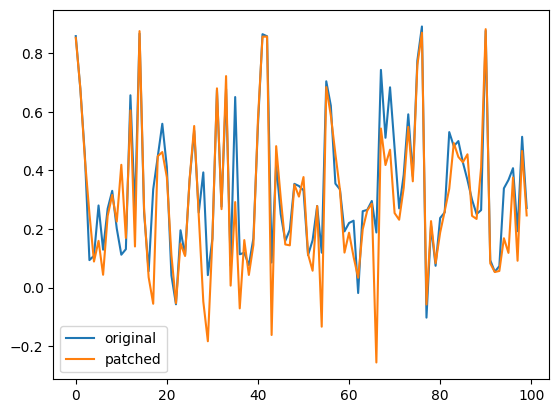

In [105]:
plt.plot(sims_original, label='original')
plt.plot(sims_patched, label='patched')
plt.legend()
plt.show()

In [106]:
np.array(sims_original).mean(), np.array(sims_patched).mean()

(0.33833466637266363, 0.29387627896295143)

In [107]:
import scipy.stats as stats
line = stats.linregress(sims_patched, sims_original)
line

LinregressResult(slope=0.8296473336282307, intercept=0.09452099511446485, rvalue=0.8945919394267459, pvalue=4.694645975730047e-36, stderr=0.04186491918507161, intercept_stderr=0.01620191637648269)

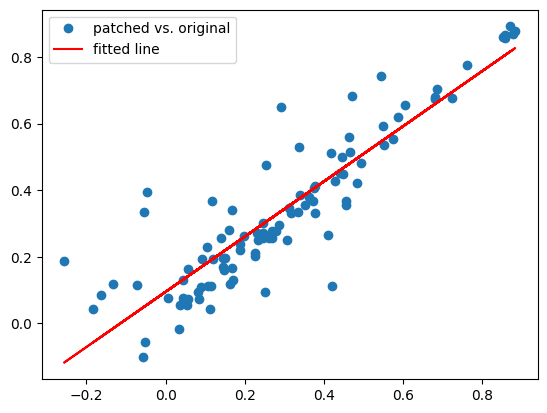

In [108]:
# plot regression line from scipy
plt.plot(sims_patched, sims_original, 'o', label='patched vs. original')
plt.plot(sims_patched, line.intercept + line.slope*np.array(sims_patched), 'r', label='fitted line')
plt.legend()
plt.show()

### Check dot product sim at decision squares

In [111]:
from procgen_tools import metrics

def _decision_square_index(vf):
    return vf['legal_mouse_positions'].index(metrics.decision_square(vf['grid']))

def decision_square_similarity(vf):
    i = _decision_square_index(vf)
    (dx, dy) = metrics.decision_square(vf['grid'])
    (cx, cy) = maze.get_cheese_pos(vf['grid'])

    return similarity((cx - dx, cy - dy), vf['arrows'][i])

-0.7619792083267357


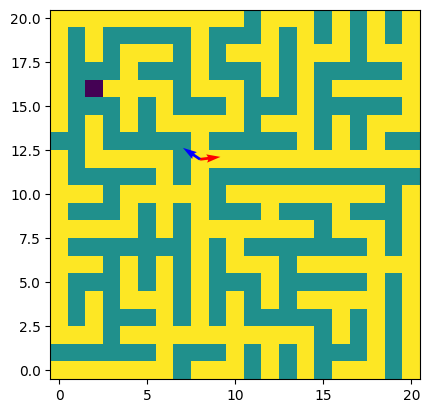

In [131]:
vfs = vfields[4]
vf = vfs['original_vfield']
i = _decision_square_index(vf)
dsq = metrics.decision_square(vf['grid'])
csq = maze.get_cheese_pos(vf['grid'])

plt.imshow(vf['grid'], origin='lower')
plt.quiver(dsq[1], dsq[0], [vf['arrows'][i][1]], [vf['arrows'][i][0]], color='red')
plt.quiver(dsq[1], dsq[0], [csq[1]-dsq[1]], [csq[0]-dsq[0]], color='blue')
print(decision_square_similarity(vf))
plt.show()

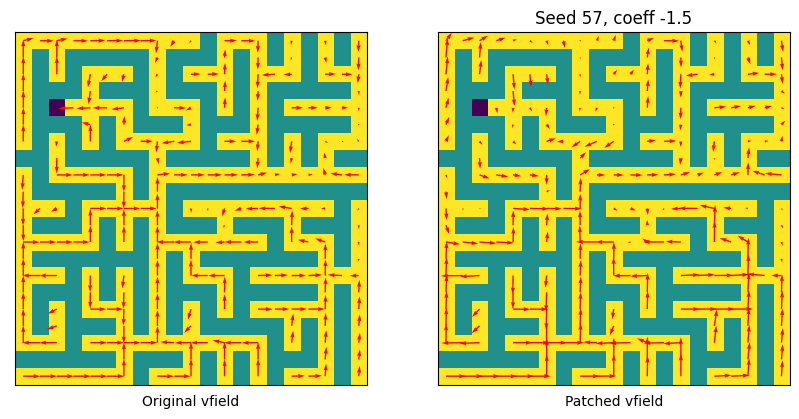

In [133]:
plot_vfs(vfs)

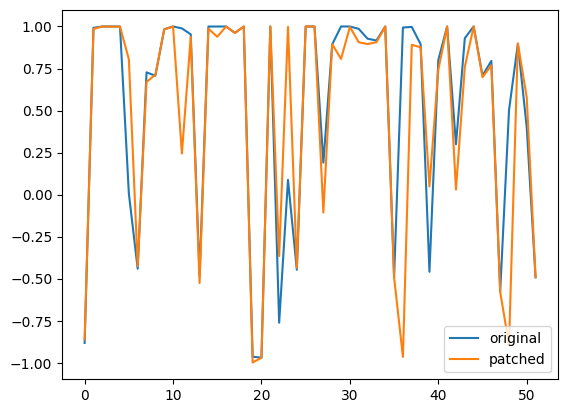

In [123]:
dsq_sim_original = []
dsq_sim_patched = []

for vfs in vfields:
    if vfs['coeff'] == -1.0 and metrics.decision_square(vfs['original_vfield']['grid']) is not None:
        dsq_sim_original.append(decision_square_similarity(vfs['original_vfield']))
        dsq_sim_patched.append(decision_square_similarity(vfs['patched_vfield']))


plt.plot(dsq_sim_original, label='original')
plt.plot(dsq_sim_patched, label='patched')
plt.legend()
plt.show()

LinregressResult(slope=0.7873027378594778, intercept=0.15455416970579283, rvalue=0.8208563282059392, pvalue=9.310832241009307e-14, stderr=0.07746904184405569, intercept_stderr=0.0645325693249246)


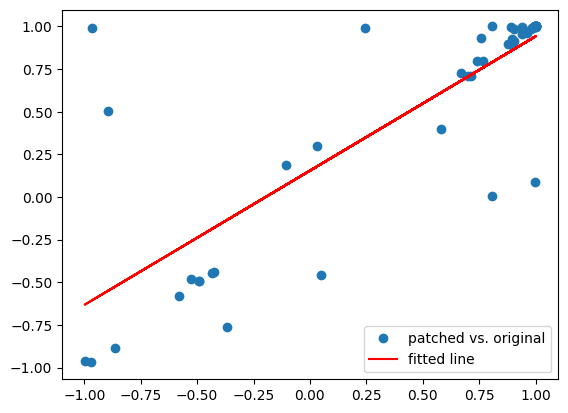

In [127]:
line = stats.linregress(dsq_sim_patched, dsq_sim_original)
print(line)
plt.plot(dsq_sim_patched, dsq_sim_original, 'o', label='patched vs. original')
plt.plot(dsq_sim_patched, line.intercept + line.slope*np.array(dsq_sim_patched), 'r', label='fitted line')
plt.legend()
plt.show()

### Probability of going the right way on the decision square

### Get step-wise dot products along the shortest path